## Технологии машинного обучения

## Практическая 2. Exploratory Data Analysis и линейная регрессия

### Кирилл Захаров

### О задании
В этом задании мы попытаемся научиться анализировать данные и выделять из них полезные признаки. Мы также научимся пользоваться `seaborn` и `sklearn`, а заодно привыкнем к основным понятиям машинного обучения.

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов. Проверяющий имеет право снизить оценку за неэффективную реализацию или неопрятные графики.

**Обратите внимание**, что в каждом разделе практического задания есть оцениваниемые задачи и есть вопросы. Вопросы дополняют задачи и направлены на то, чтобы проинтерпретировать или обосновать происходящее. Код без интерпретации не имеет смысла, поэтому отвечать на вопросы обязательно — за отсутствие ответов мы будем снижать баллы за задачи.

В этом ноутбуке используется библиотека `folium` для визуализации карт. Она работает в google colab!

In [1]:
!pip install folium

In [2]:
import folium

m = folium.Map(location=(55.7522200, 37.6155600), zoom_start=10)

m

Если вы всё сделали правильно, то выше должна открыться карта Москвы.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy

%matplotlib inline

sns.set(style="darkgrid")

## Часть 0. Подготовка (1 балл)

**Задание 1 (1 балл)**. Мы будем работать с данными из соревнования [New York City Taxi Trip Duration](https://www.kaggle.com/c/nyc-taxi-trip-duration/overview), в котором нужно было предсказать длительность поездки на такси. Скачайте обучающую выборку из этого соревнования и загрузите ее:

In [4]:
data = pd.read_csv('Data_taxi/train.csv')

In [5]:
data_copy = copy.deepcopy(data)

In [6]:
data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [7]:
data.shape

(1458644, 11)

Обратите внимание на колонки `pickup_datetime` и `dropoff_datetime`. `dropoff_datetime` был добавлена организаторами только в обучающую выборку, то есть использовать эту колонку нельзя, давайте удалим ее. В `pickup_datetime` записаны дата и время начала поездки. Чтобы с ней было удобно работать, давайте преобразуем даты в `datetime`-объекты

In [8]:
data = data.drop('dropoff_datetime', axis=1)

In [9]:
data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'])

In [10]:
data['pickup_datetime'].dtype

dtype('<M8[ns]')

В колонке `trip_duration` записано целевое значение, которое мы хотим предсказывать. Давайте посмотрим на распределение таргета в обучающей выборке. Для этого нарисуйте его гистограмму:

In [11]:
data['trip_duration'].value_counts()

368      1624
408      1584
348      1582
367      1581
358      1577
         ... 
7378        1
83250       1
6615        1
34014       1
6124        1
Name: trip_duration, Length: 7417, dtype: int64

Так как в выборке есть выбросы с очень большими значениями, добавим range в параметры hist для информативного отображения гистограммы.

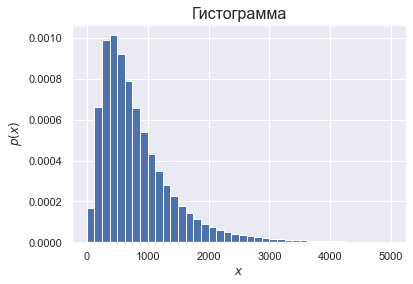

In [12]:
plt.hist(data['trip_duration'], bins=40, range=(0, 5000), density=True)

plt.title('Гистограмма', fontsize=16)
plt.xlabel('$x$')
plt.ylabel('$p(x)$')
plt.show()

**Вопрос**: Что можно сказать о целевой переменной по гистограмме её значений?

**Ответ:** Если убрать выбросы, то распределение лог-нормальное.

В соревновании в качестве метрики качества использовалось RMSLE:
$$\text{RMSLE}(X, y, a) = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\log{(y_i + 1)} - \log{(a(x_i) + 1)}\big)^2}$$

**Вопрос**: Как вы думаете, почему авторы соревнования выбрали именно RMSLE, а не RMSE?

**Ответ:** Потому что в выборке есть очень большие значения, логарифмы уменьшат ошибку. Также мы не хотим штрафовать за большую ошибку, которая возникнет, при больших значениях признаков: предсказанного и истинного.

Сведем задачу оптимизации RMSLE к MSE. Давайте проделаем следующий трюк: будем предсказывать не целевую переменную, а ее *логарифм*. Обозначим $\hat{y}_i = \log{(y_i + 1)}$ — модифицированный таргет, а $\hat{a}(x_i)$ — предсказание модели, которая обучалась на $\hat{y}_i$, то есть логарифм таргета. Чтобы предсказать исходное значение, мы можем просто взять экспоненту от нашего предсказания: $a(x_i) = \exp(\hat{a}(x_i)) - 1$.

Итак, мы смогли свести задачу оптимизации RMSLE к задаче оптимизации MSE, которую мы умеем решать! Кроме того, у логарифмирования таргета есть еще одно полезное свойство. Чтобы его увидеть, добавьте к нашей выборке колонку `log_trip_duration` (воспользуйтесь `np.log1p`) и нарисуйте гистограмму модифицированного таргета по обучающей выборке. Удалите колонку со старым таргетом.

In [13]:
data['log_trip_duration'] = np.log1p(data['trip_duration'])

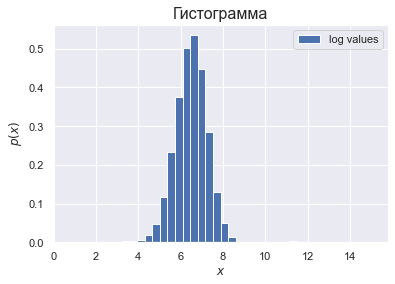

In [14]:
data['log_trip_duration'].hist(bins=40, density=True, label='log values')

plt.title('Гистограмма', fontsize=16)
plt.xlabel('$x$')
plt.ylabel('$p(x)$')
plt.legend()
plt.show()

In [15]:
data = data.drop('trip_duration', axis=1)

In [16]:
data = data.dropna()

Чтобы иметь некоторую точку отсчета, давайте посчитаем значение метрики при наилучшем константном предсказании:

In [17]:
from sklearn.metrics import mean_squared_log_error

In [18]:
np.sqrt(mean_squared_log_error(data['log_trip_duration'], [data['log_trip_duration'].mean()]*len(data)))

0.11334510822453138

## Часть 1. Изучаем `pickup_datetime` (2 балла)

**Задание 2 (0.25 баллов)**. Для начала давайте посмотрим, сколько всего было поездок в каждый из дней. Постройте график зависимости количества поездок от дня в году (например, можно воспользоваться `sns.countplot`):

In [19]:
data['pickup_datetime'].dt.dayofyear.value_counts()

100    9796
107    9602
65     9597
93     9325
44     9309
       ... 
3      6353
25     6084
151    5570
24     3383
23     1648
Name: pickup_datetime, Length: 182, dtype: int64

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


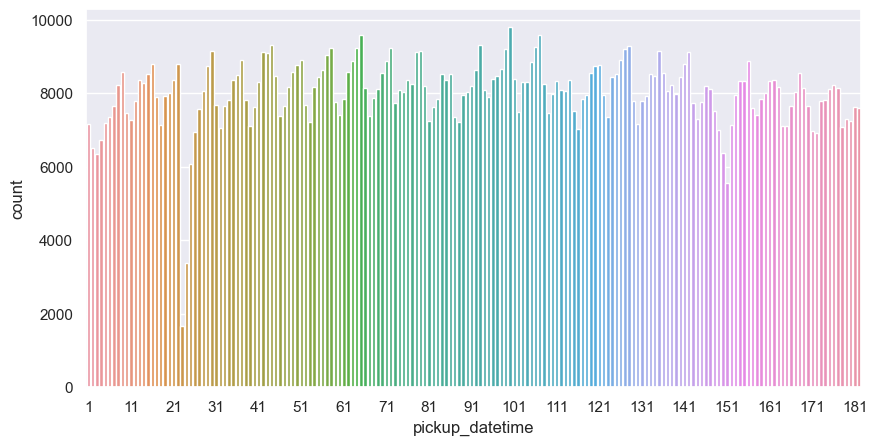

In [20]:
plt.subplots(figsize=(10, 5), dpi=100)

sns.countplot(data['pickup_datetime'].dt.dayofyear)

plt.xticks(np.arange(0, data['pickup_datetime'].dt.dayofyear.max(), 10))
plt.show()

**Вопрос**: Вы, вероятно, заметили, что на графике есть 2 периода с аномально маленькими количествами поездок. Вычислите, в какие даты происходили эти скачки вниз и найдите информацию о том, что происходило в эти дни в Нью-Йорке.

Нарисуйте графики зависимости количества поездок от дня недели и от часов в сутках (воспользуйтесь `sns.relplot`):

In [21]:
day_23 = data['pickup_datetime'].loc[np.where(data['pickup_datetime'].dt.day == 23)[0]]

In [22]:
day_23.dt.month.value_counts()

4    8352
2    8172
6    8126
3    7852
5    7300
1    1648
Name: pickup_datetime, dtype: int64

На графике видно, что провал примерно в 23 числах. Посмотрим теперь на все месяцы и увидим, что в январе есть просадка. В период с 21 по 29 января 2016 года в Нью-Йорке была аномальная снежная буря, из-за этого число поездок сократилось.

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


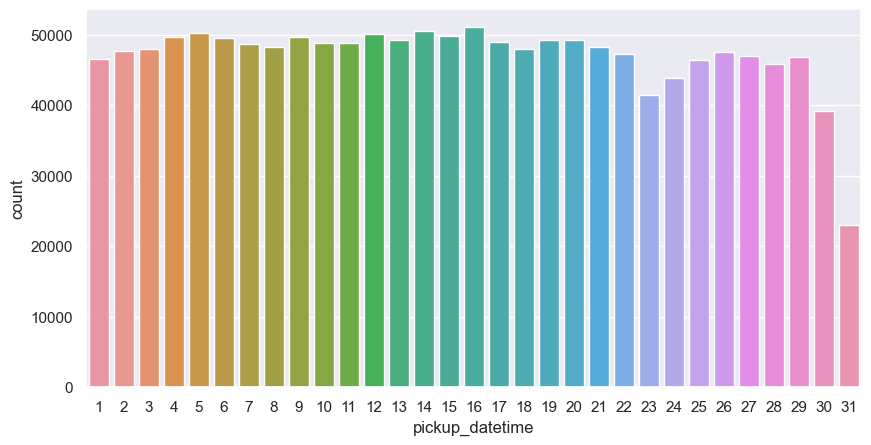

In [23]:
plt.subplots(figsize=(10, 5), dpi=100)

sns.countplot(data['pickup_datetime'].dt.day)

plt.show()

Посмотрим на даты по месяцам, видим просадки, но уже по месяцам. Также видна 23 и новая просадка в 30 числах, 31 не считаем, т.к. 31 день всего в 7 месяцах просадка из-за этого.

In [24]:
day_30 = data['pickup_datetime'].loc[np.where(data['pickup_datetime'].dt.day == 30)[0]]

In [25]:
day_30.dt.month.value_counts()

1    9166
4    8780
3    8031
6    7588
5    5570
Name: pickup_datetime, dtype: int64

Как видно 30 мая 2016 года была просадка, в это время в Нью-Йорке был сильный дождь и гроза, вероятно люди меньше выходили из дома.

In [26]:
hours_count = data['pickup_datetime'].dt.hour.value_counts()

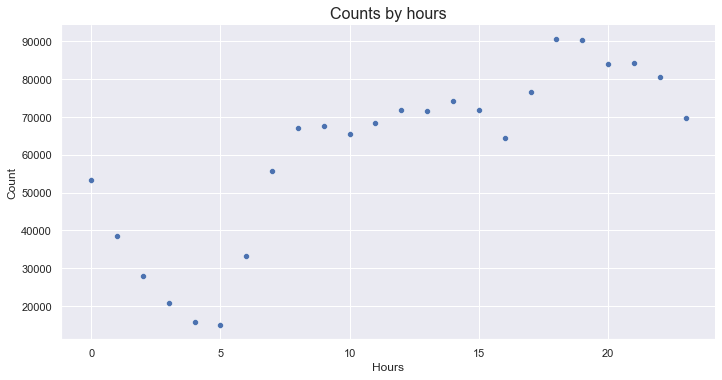

In [27]:
sns.relplot(x=hours_count.index, y=hours_count, aspect=2)

plt.title('Counts by hours', fontsize=16)
plt.xlabel('Hours')
plt.ylabel('Count')
plt.show()

In [28]:
dayofweek_count = data['pickup_datetime'].dt.dayofweek.value_counts()
weeks_str = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']

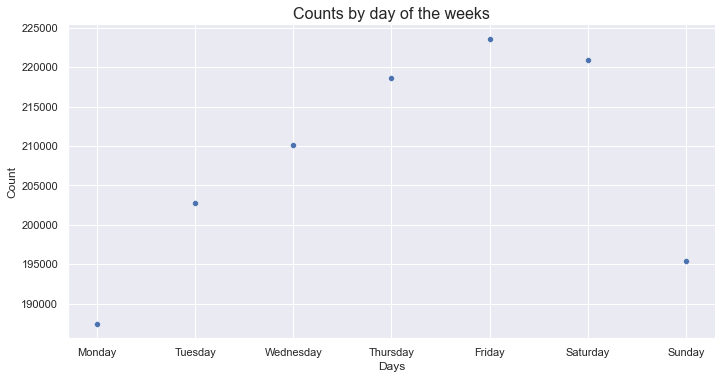

In [29]:
sns.relplot(x=dayofweek_count.index, y=dayofweek_count, aspect=2)

plt.title('Counts by day of the weeks', fontsize=16)
plt.xlabel('Days')
plt.ylabel('Count')
plt.xticks(range(7), weeks_str)
plt.show()

Наибольшая активность по пятницам и субботам, что логично, люди после работы отдыхают. По часам также видно, что наиболее активны поездки в вечернее время.

**Задание 3 (0.5 баллов)**. Нарисуйте на одном графике зависимости количества поездок от часа в сутках для разных месяцев (разные кривые, соответствующие разным месяцам, окрашивайте в разные цвета, воспользуйтесь `hue` в `sns.relplot`). Аналогично нарисуйте зависимости количества поездок от часа в сутках для разных дней недели.

In [30]:
data1 = copy.copy(data)

In [31]:
data1['month'] = data['pickup_datetime'].dt.month #выделим месяца

In [32]:
#далее посчитаем по каждому месяцу количество поездок по часам 
month_hours_counts = data1.groupby('month')['pickup_datetime'].apply(lambda x: x.dt.hour.value_counts())
month_hours_counts = month_hours_counts.to_frame().reset_index()
#немного красоты
month_hours_counts = month_hours_counts.rename(columns = {'level_1': 'hour', 'pickup_datetime': 'counts'})

In [33]:
month_hours_counts

,month,hour,counts
0,1,18,14402
1,1,19,14116
2,1,20,13250
3,1,21,12823
4,1,17,12538
...,...,...,...
139,6,6,5674
140,6,2,4451
141,6,3,3305
142,6,4,2570


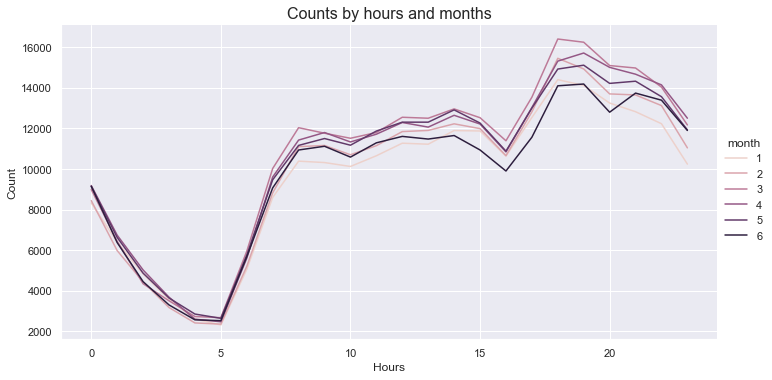

In [34]:
sns.relplot(data=month_hours_counts, x='hour', y='counts', hue='month', aspect=2, kind='line')

plt.title('Counts by hours and months', fontsize=16)
plt.xlabel('Hours')
plt.ylabel('Count')
plt.show()

In [35]:
data1['week'] = data['pickup_datetime'].dt.dayofweek

In [36]:
week_hours_counts = data1.groupby('week')['pickup_datetime'].apply(lambda x: x.dt.hour.value_counts())
week_hours_counts = week_hours_counts.to_frame().reset_index()
week_hours_counts = week_hours_counts.rename(columns = {'level_1': 'hour', 'pickup_datetime': 'counts'})
week_hours_counts['week'] = week_hours_counts.week.replace(range(7), weeks_str)

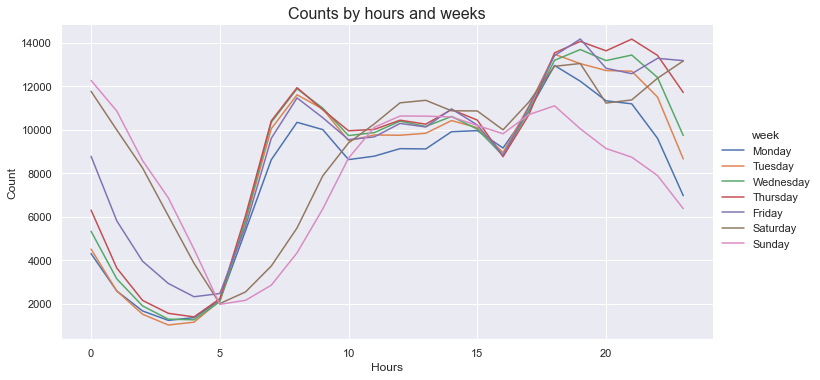

In [37]:
sns.relplot(data=week_hours_counts, x='hour', y='counts', hue='week', aspect=2, kind='line')

plt.title('Counts by hours and weeks', fontsize=16)
plt.xlabel('Hours')
plt.ylabel('Count')
plt.show()

**Вопрос**: Какие выводы можно сделать, основываясь на графиках выше? Выделяются ли какие-нибудь дни недели? Месяца? Время суток? С чем это связано?

**Ответ**: Наибольшая активность по пятницам и субботам, что логично, люди после работы отдыхают, еду куда-нибудь на такси. По часам также видно, что наиболее активны поездки в вечернее время. А утрення активность по субботам и воскресеньям низкая.

**Задание 4 (0.5 баллов)**. Разбейте выборку на обучающую и тестовую в отношении 7:3. По обучающей выборке нарисуйте график зависимости среднего логарифма времени поездки от дня недели. Затем сделайте то же самое, но для часа в сутках и дня в году.

In [38]:
from sklearn.model_selection import train_test_split

In [39]:
X_train, X_test, y_train, y_test = train_test_split(data.iloc[:,:-1], data.log_trip_duration, test_size=0.3)

In [40]:
X_train1 = copy.copy(X_train)
X_train1['day'] = X_train['pickup_datetime'].dt.dayofweek
X_train1['hour'] = X_train['pickup_datetime'].dt.hour
X_train1['day_year'] = X_train['pickup_datetime'].dt.dayofyear
X_train1['y'] = y_train.values

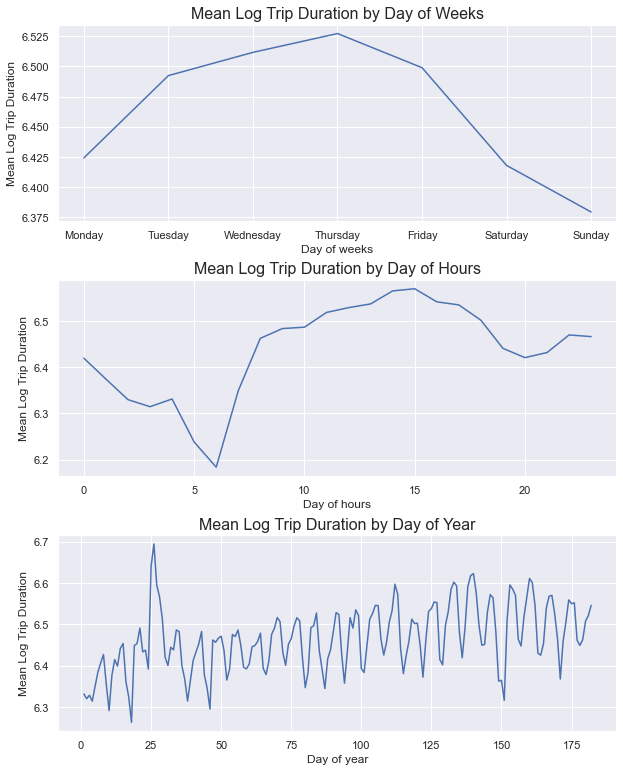

In [41]:
fig, axs = plt.subplots(3, 1, figsize=(10, 13))

axs[0].plot(X_train1.groupby('day')['y'].mean())
axs[0].set_title('Mean Log Trip Duration by Day of Weeks', fontsize=16)
axs[0].set_xlabel('Day of weeks')
axs[0].set_ylabel('Mean Log Trip Duration')
axs[0].set_xticks(range(7), weeks_str)


axs[1].plot(X_train1.groupby('hour')['y'].mean())
axs[1].set_title('Mean Log Trip Duration by Day of Hours', fontsize=16)
axs[1].set_xlabel('Day of hours')
axs[1].set_ylabel('Mean Log Trip Duration')
# axs[1].set_xticks(range(7), weeks_str)


axs[2].plot(X_train1.groupby('day_year')['y'].mean())
axs[2].set_title('Mean Log Trip Duration by Day of Year', fontsize=16)
axs[2].set_xlabel('Day of year')
axs[2].set_ylabel('Mean Log Trip Duration')
# axs[2].set_xticks(range(7), weeks_str)

plt.subplots_adjust(hspace=0.3)
plt.show()

**Вопрос**: Похожи ли графики зависимости таргета от дня недели и от часа в сутках на аналогичные графики для количества поездок? Почему? Что происходит со средним таргетом в те два аномальных периода, что мы видели выше? Почему так происходит? Наблюдаете ли вы какой-нибудь тренд на графике зависимости `log_trip_duration` от номера дня в году?

**Ответ**: Похожи, особенно часы, так как чем больше поездок тем в среднем и больше времени будет затрачиваться.

Добавьте следующие признаки на основе `pickup_datetime`:
1. День недели
2. Месяц
3. Час
4. Является ли период аномальным (два бинарных признака, соответствующие двум аномальным периодам)
5. Номер дня в году

In [42]:
X_train['dayofweek'] = X_train['pickup_datetime'].dt.dayofweek
X_train['month'] = X_train['pickup_datetime'].dt.month
X_train['hour'] = X_train['pickup_datetime'].dt.hour
X_train['dayofyear'] = X_train['pickup_datetime'].dt.dayofyear
X_train['anom1'] = np.zeros(len(X_train))
X_train['anom2'] = np.zeros(len(X_train))

In [43]:
x_anom1 = X_train[X_train['pickup_datetime'].dt.date == pd.to_datetime('2016-01-23').date()].index
(X_train.loc[x_anom1, 'anom1']) = np.ones(len(x_anom1))

In [44]:
x_anom2 = X_train[X_train['pickup_datetime'].dt.date == pd.to_datetime('2016-05-30').date()].index
(X_train.loc[x_anom2, 'anom2']) = np.ones(len(x_anom2))

In [45]:
X_train

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,dayofweek,month,hour,dayofyear,anom1,anom2
552607,id2353861,1,2016-05-17 19:57:07,1,-73.991043,40.745693,-73.961548,40.764400,N,1,5,19,138,0.0,0.0
92034,id3579421,2,2016-02-05 20:34:55,1,-73.989281,40.741940,-73.980247,40.744270,N,4,2,20,36,0.0,0.0
1217977,id3613832,1,2016-06-12 04:22:37,1,-73.989433,40.726254,-74.000450,40.727173,N,6,6,4,164,0.0,0.0
72594,id0001586,1,2016-02-13 16:33:50,1,-73.979195,40.745667,-74.008286,40.713181,N,5,2,16,44,0.0,0.0
599787,id2837452,1,2016-06-09 10:43:47,1,-73.969254,40.800163,-73.971451,40.783634,N,3,6,10,161,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1314505,id3713021,1,2016-01-10 20:14:16,1,-73.982857,40.758556,-73.992088,40.746708,N,6,1,20,10,0.0,0.0
336502,id0854352,1,2016-05-31 18:41:17,1,-73.968735,40.761917,-73.963753,40.763725,N,1,5,18,152,0.0,0.0
53324,id3640278,2,2016-03-03 06:53:41,1,-73.977180,40.764168,-73.963074,40.803982,N,3,3,6,63,0.0,0.0
279309,id1710482,2,2016-06-16 06:46:01,2,-73.989166,40.776951,-73.969131,40.762089,N,3,6,6,168,0.0,0.0


Итак, мы уже создали некоторое количество признаков.

**Вопрос**: Какие из признаков стоит рассматривать как категориальные, а какие - как численные? Почему? 

**Ответ**: День недели, месяц, день в году и два бинарных являются категориальными, так как не имеют численного представления, то есть это фиксированные состояния и например, между днями недели промежуточных значений нет. Численным признаком здесь может являться час поездки, так как имеет числовой смысл, есть промежуточные значения.

**Задание 5 (0.75 баллов)**. Обучите `Ridge`-регрессию с параметрами по умолчанию, закодировав все категориальные признаки с помощью `OneHotEncoder`. Численные признаки отмасштабируйте с помощью `StandardScaler`. Используйте только признаки, которые мы выделили в этой части задания.

In [46]:
X_train_cat = X_train[['dayofweek', 'month', 'dayofyear', 'anom1', 'anom2']]
X_train_num = X_train[['hour']]

In [47]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_num = scaler.fit_transform(X_train_num)

In [48]:
X_train_cat_oh = pd.get_dummies(X_train_cat.iloc[:, :-2].astype(str))

In [49]:
X_train2 = pd.concat([X_train_cat_oh, X_train_cat.iloc[:,-2:], pd.DataFrame(X_train_num, index=X_train_cat_oh.index)], axis=1)

In [50]:
X_train2

,dayofweek_0,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6,month_1,month_2,month_3,...,dayofyear_93,dayofyear_94,dayofyear_95,dayofyear_96,dayofyear_97,dayofyear_98,dayofyear_99,anom1,anom2,0
552607,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,0.0,0.842804
92034,0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0.0,0.0,0.999087
1217977,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0.0,0.0,-1.501438
72594,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0.0,0.0,0.373956
599787,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,0.0,-0.563741
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1314505,0,0,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0.0,0.0,0.999087
336502,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,0.0,0.686521
53324,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0.0,0.0,-1.188872
279309,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,0.0,-1.188872


In [51]:
X_test['dayofweek'] = X_test['pickup_datetime'].dt.dayofweek
X_test['month'] = X_test['pickup_datetime'].dt.month
X_test['hour'] = X_test['pickup_datetime'].dt.hour
X_test['dayofyear'] = X_test['pickup_datetime'].dt.dayofyear
X_test['anom1'] = np.zeros(len(X_test))
X_test['anom2'] = np.zeros(len(X_test))
x_anom1 = X_test[X_test['pickup_datetime'].dt.date == pd.to_datetime('2016-01-23').date()].index
(X_test.loc[x_anom1, 'anom1']) = np.ones(len(x_anom1))
x_anom2 = X_test[X_test['pickup_datetime'].dt.date == pd.to_datetime('2016-05-30').date()].index
(X_test.loc[x_anom2, 'anom2']) = np.ones(len(x_anom2))

X_test_cat = X_test[['dayofweek', 'month', 'dayofyear', 'anom1', 'anom2']]
X_test_num = X_test[['hour']]

scaler = StandardScaler()

X_test_num = scaler.fit_transform(X_test_num)
X_test_cat_oh = pd.get_dummies(X_test_cat.iloc[:, :-2].astype(str))
X_test2 = pd.concat([X_test_cat_oh, X_test_cat.iloc[:,-2:], pd.DataFrame(X_test_num, index=X_test_cat_oh.index)], axis=1)

In [52]:
from sklearn.linear_model import Ridge

In [53]:
ridge = Ridge()

In [54]:
ridge.fit(X_train2.values, y_train.values)

Ridge()

In [55]:
prediction2 = ridge.predict(X_test2.values)

In [56]:
mean_squared_log_error(y_test, prediction2)

0.012681226621333435

## Часть 2. Изучаем координаты (3 балла)
Мы уже очень хорошо изучили данные о времени начала поездки, давайте теперь посмотрим на информацию о координатах начала и конца поездки. Мы подготовили для вас функцию, которая на карте рисует точки начала или конца поездки. Примеры ее вызова вы найдете ниже. Обратите внимание, что в эту функцию мы передаем лишь небольшой кусочек данных, посколько иначе функция будет работать очень долго

In [57]:
def show_circles_on_map(data, latitude_column, longitude_column, color):
    """
    The function draws map with circles on it.
    The center of the map is the mean of coordinates passed in data.
    
    data: DataFrame that contains columns latitude_column and longitude_column
    latitude_column: string, the name of column for latitude coordinates
    longitude_column: string, the name of column for longitude coordinates
    color: string, the color of circles to be drawn
    """

    location = (data[latitude_column].mean(), data[longitude_column].mean())
    m = folium.Map(location=location)

    for _, row in data.iterrows():
        folium.Circle(
            radius=5,
            location=(row[latitude_column], row[longitude_column]),
            color=color,
            fill_color=color,
            fill=False
        ).add_to(m)

    return m

In [58]:
df1 = data.sample(1000)

In [59]:
show_circles_on_map(df1, "pickup_latitude", "pickup_longitude", "blue")

In [60]:
show_circles_on_map(df1, "dropoff_latitude", "dropoff_longitude", "blue")

**Вопрос**: Какие две точки выделяются на карте? 

**Ответ**: Выделяются два аэропорта Джона Кеннеди и аэропорт Ла-Гуардия

**Задание 6 (0.75 балл)**. Как мы все прекрасно помним, $t = s / v_{\text{ср}}$, поэтому очевидно, что самым сильным признаком будет расстояние, которое необходимо проехать. Мы не можем посчитать точное расстояние, которое необходимо преодолеть такси, но мы можем его оценить, посчитав кратчайшее расстояние между точками начала и конца поездки. Чтобы корректно посчитать расстояние между двумя точками на Земле, можно использовать функцию `haversine`. Также можно воспользоваться кодом с первого семинара. Посчитайте кратчайшее расстояние для объектов и запишите его в колонку `haversine`:

In [61]:
from sklearn.metrics.pairwise import haversine_distances

In [62]:
df = X_train

In [63]:
df['haversine'] = np.array(list(map(lambda x,y: haversine_distances([x], [y]), np.array([df['pickup_longitude'], df['pickup_latitude']]).T,\
                    np.array([df['dropoff_longitude'], df['dropoff_latitude']]).T))).reshape(-1, 1)

In [64]:
X_test['haversine'] = np.array(list(map(lambda x,y: haversine_distances([x], [y]), np.array([X_test['pickup_longitude'], X_test['pickup_latitude']]).T,\
                    np.array([X_test['dropoff_longitude'], X_test['dropoff_latitude']]).T))).reshape(-1, 1)

Так как мы предсказываем логарифм времени поездки и хотим, чтобы наши признаки были линейно зависимы с этой целевой переменной, нам нужно логарифмировать расстояние: $\log t = \log s - \log{v_{\text{ср}}}$. Запишите логарифм `haversine` в отдельную колонку:

In [65]:
df['log_haversine'] = np.log1p(df['haversine'])
X_test['log_haversine'] = np.log1p(X_test['haversine'])

Убедимся, что логарифм расстояния лучше коррелирует с нашим таргетом, чем просто расстояние:

In [66]:
from scipy.stats import pearsonr

In [67]:
pearsonr(df['log_haversine'], y_train)

(0.5442888267477527, 0.0)

In [68]:
pearsonr(df['haversine'], y_train)

(0.5307204079549477, 0.0)

**Задание 7 (0.75 балла)**. Давайте изучим среднюю скорость движения такси. Посчитайте среднюю скорость для каждого объекта обучающей выборки, разделив `haversine` на `trip_duration`, и нарисуйте гистограмму ее распределения

In [69]:
avg_velocity = df['log_haversine']/y_train

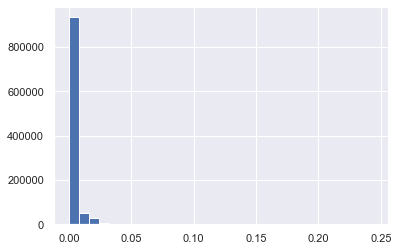

In [70]:
plt.hist(avg_velocity, bins=30)

plt.show()

Как можно видеть по гистограмме, для некоторых объектов у нас получились очень больше значения скоростей. Нарисуйте гистограмму по объектам, для которых значение скорости получилось разумным (например, можно не включать рассмотрение объекты, где скорость больше некоторой квантили):

In [71]:
avg_velocity_q = avg_velocity.values[np.where(avg_velocity <= np.quantile(avg_velocity, 0.75))[0]]

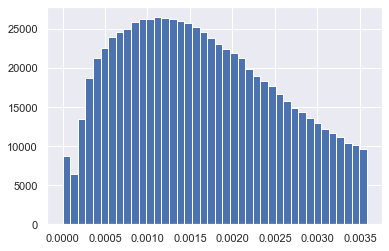

In [72]:
plt.hist(avg_velocity_q, bins=40)

plt.show()

Для каждой пары (день недели, час суток) посчитайте медиану скоростей. Нарисуйте с помощью `sns.heatmap` график, где по осям будут дни недели и часы, а в качестве значения функции - медиана скорости

In [73]:
df['avg_velocity'] = avg_velocity

In [74]:
velocity_median = df.groupby(['dayofweek', 'hour']).apply(lambda x: np.median(x['avg_velocity'])).to_frame().reset_index()

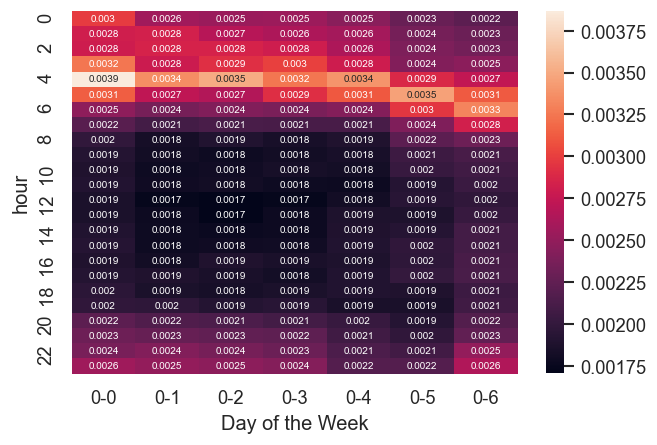

In [75]:
plt.subplots(dpi=120)

sns.heatmap(velocity_median.pivot(index='hour',columns=['dayofweek']), annot=True, annot_kws={"size":6})

plt.xlabel('Day of the Week')
plt.show()

Не забудьте удалить колонку со значением скорости из данных!

**Вопрос**: Почему значение скорости нельзя использовать во время обучения?

**Ответ**: Потому что будут коррелированные признаки

In [76]:
X_train = X_train.drop('avg_velocity', axis=1)

**Вопрос**: Посмотрите внимательно на график и скажите, в какие моменты времени скорость минимальна; максимальна.

**Ответ**: Скорость минимальна в будни в часы пробок. Максимальная по вечерам и рано утром и на выходных

Создайте признаки "поездка совершается в период пробок" и "поездка совершается в период свободных дорог" (естественно, они не должен зависеть от скорости!):

#### Поскольку нельзя использовать скорость, то воспользуемсся примерным временным диапозоном по графику выше, когда есть пробки

In [77]:
X_train['traffic'] = np.zeros(len(X_train))
X_train['free'] = np.zeros(len(X_train))

In [78]:
idx_traffic = X_train[(X_train['hour'] <= 19) & (X_train['hour'] >= 8) &\
                      (X_train['dayofweek'].isin(np.arange(5)))].index

In [79]:
X_train.loc[idx_traffic,'traffic'] = np.ones(len(idx_traffic))

In [80]:
X_train.loc[~X_train.index.isin(idx_traffic), 'free'] = np.ones(len(X_train) - len(idx_traffic))

In [81]:
X_train.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,dayofweek,month,hour,dayofyear,anom1,anom2,haversine,log_haversine,traffic,free
552607,id2353861,1,2016-05-17 19:57:07,1,-73.991043,40.745693,-73.961548,40.764400,N,1,5,19,138,0.0,0.0,0.029624,0.029194,1.0,0.0
92034,id3579421,2,2016-02-05 20:34:55,1,-73.989281,40.741940,-73.980247,40.744270,N,4,2,20,36,0.0,0.0,0.009041,0.009000,0.0,1.0
1217977,id3613832,1,2016-06-12 04:22:37,1,-73.989433,40.726254,-74.000450,40.727173,N,6,6,4,164,0.0,0.0,0.011018,0.010958,0.0,1.0
72594,id0001586,1,2016-02-13 16:33:50,1,-73.979195,40.745667,-74.008286,40.713181,N,5,2,16,44,0.0,0.0,0.029580,0.029151,0.0,1.0
599787,id2837452,1,2016-06-09 10:43:47,1,-73.969254,40.800163,-73.971451,40.783634,N,3,6,10,161,0.0,0.0,0.003220,0.003215,1.0,0.0


**Задание 8 (0.25 балла)**. Как уже было замечено выше, на карте выделяются две точки вдали от Манхэттена. Для каждой из них добавьте в выборку два признака: началась ли поездка в ней и закончилась ли она в ней.

In [82]:
X_train['spec_start1'] = np.zeros(len(X_train)).astype(int)
X_train['spec_start2'] = np.zeros(len(X_train)).astype(int)
X_train['spec_end1'] = np.zeros(len(X_train)).astype(int)
X_train['spec_end2'] =np.zeros(len(X_train)).astype(int)

X_test['spec_start1'] = np.zeros(len(X_test)).astype(int)
X_test['spec_start2'] = np.zeros(len(X_test)).astype(int)
X_test['spec_end1'] = np.zeros(len(X_test)).astype(int)
X_test['spec_end2'] =np.zeros(len(X_test)).astype(int)

По данным можно сузить круг, где находятся аэропорты и выделить следующие координаты

In [83]:
def airport_1_coord(data, lat, lon):
    return ((40.761 < data[lat]) & (data[lat] < 40.779) & (-73.88 < data[lon]) & (data[lon] < -73.86))
def airport_2_coord(data, lat,lon):
    return ((40.625 < data[lat]) & (data[lat] < 40.665) & (-73.8 < data[lon]) & (data[lon] < -73.77))

In [84]:
X_train.loc[airport_1_coord(X_train, 'pickup_latitude','pickup_longitude'), 'spec_start1'] = 1
X_train.loc[airport_2_coord(X_train, 'pickup_latitude','pickup_longitude'), 'spec_start2'] = 1

X_train.loc[airport_1_coord(X_train, 'dropoff_latitude','dropoff_longitude'), 'spec_end1'] = 1
X_train.loc[airport_2_coord(X_train, 'dropoff_latitude','dropoff_longitude'), 'spec_end2'] = 1

X_test.loc[airport_1_coord(X_test, 'pickup_latitude','pickup_longitude'), 'spec_start1'] = 1
X_test.loc[airport_2_coord(X_test, 'pickup_latitude','pickup_longitude'), 'spec_start2'] = 1

X_test.loc[airport_1_coord(X_test, 'dropoff_latitude','dropoff_longitude'), 'spec_end1'] = 1
X_test.loc[airport_2_coord(X_test, 'dropoff_latitude','dropoff_longitude'), 'spec_end2'] = 1

In [85]:
X_train.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,dayofweek,...,anom1,anom2,haversine,log_haversine,traffic,free,spec_start1,spec_start2,spec_end1,spec_end2
552607,id2353861,1,2016-05-17 19:57:07,1,-73.991043,40.745693,-73.961548,40.764400,N,1,...,0.0,0.0,0.029624,0.029194,1.0,0.0,0,0,0,0
92034,id3579421,2,2016-02-05 20:34:55,1,-73.989281,40.741940,-73.980247,40.744270,N,4,...,0.0,0.0,0.009041,0.009000,0.0,1.0,0,0,0,0
1217977,id3613832,1,2016-06-12 04:22:37,1,-73.989433,40.726254,-74.000450,40.727173,N,6,...,0.0,0.0,0.011018,0.010958,0.0,1.0,0,0,0,0
72594,id0001586,1,2016-02-13 16:33:50,1,-73.979195,40.745667,-74.008286,40.713181,N,5,...,0.0,0.0,0.029580,0.029151,0.0,1.0,0,0,0,0
599787,id2837452,1,2016-06-09 10:43:47,1,-73.969254,40.800163,-73.971451,40.783634,N,3,...,0.0,0.0,0.003220,0.003215,1.0,0.0,0,0,0,0


Для каждого из созданных признаков нарисуйте "ящик с усами" (`sns.boxplot`) распределения логарифма времени поездки

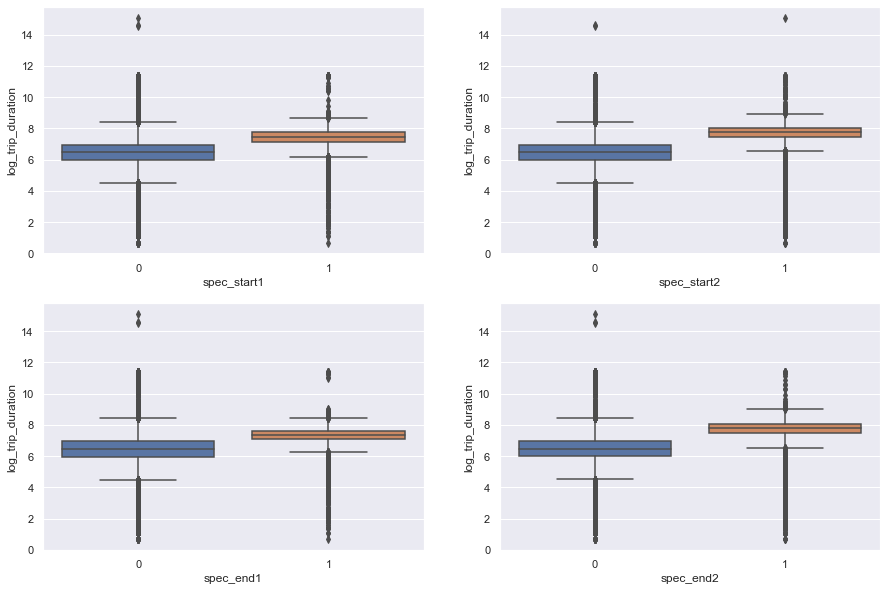

In [86]:
fig, axs = plt.subplots(2,2, figsize=(15, 10))

sns.boxplot(x=X_train['spec_start1'], y=y_train, ax=axs[0, 0])
sns.boxplot(x=X_train['spec_start2'], y=y_train, ax=axs[0, 1])
sns.boxplot(x=X_train['spec_end1'], y=y_train, ax=axs[1, 0])
sns.boxplot(x=X_train['spec_end2'], y=y_train, ax=axs[1, 1])

plt.show()

**Вопрос**: судя по графикам, как вы думаете, хорошими ли получились эти признаки?

**Ответ**: Да, т.к. поездки в аэропорт занимают больше времени, что соответствует реальности

<img src="https://www.dropbox.com/s/xson9nukz5hba7c/map.png?raw=1" align="right" width="20%" style="margin-left: 20px; margin-bottom: 20px">

**Задание 9 (1 балл)**. Сейчас мы почти что не используем сами значения координат. На это есть несколько причин: по отдельности рассматривать широту и долготу не имеет особого смысла, стоит рассматривать их вместе. Во-вторых, понятно, что зависимость между нашим таргетом и координатами не линейная. Чтобы как-то использовать координаты, можно прибегнуть к следующему трюку: обрамим область с наибольшим количеством поездок прямоугольником (как на рисунке). Разобьем этот прямоугольник на ячейки. Каждой точке сопоставим номер ее ячейки, а тем точкам, что не попали ни в одну из ячеек, сопоставим значение -1.

Напишите трансформер, который сначала разбивает показанную на рисунке область на ячейки, а затем создает два признака: номер ячейки, в которой началась поездка, и номер ячейки, в которой закончилась поездка. Количество строк и столбцов выберите самостоятельно.

Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики (если они вдруг нужны) нужно считать только по обучающей выборке в методе `fit`:

In [109]:
from sklearn.base import BaseEstimator, TransformerMixin

class MapGridTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X=None, y=None):
        self.X = copy.deepcopy(X)
        
        bot_bound_lat = [40.79, 40.76, 40.73, 40.70] #идем с шагом три для 4 ячеек
        up_bound_lat = [40.82, 40.79, 40.76, 40.73] 
        
        bot_bound_lon = [-74.02, -73.99, -73.96] #аналогично, но для 3 ячеек
        up_bound_lon = [-73.99, -73.96, -73.93]

        self.X['grid_start'] = np.array([-1]*len(self.X))
        self.X['grid_end'] = np.array([-1]*len(self.X))
        
        self.masks_start = []
        self.masks_end = []
        
        for i in range(4):
            for j in range(3):
                self.mask_start =  [((self.X['pickup_latitude'] > bot_bound_lat[i]) & (self.X['pickup_latitude'] < up_bound_lat[i]) & (self.X['pickup_longitude'] > bot_bound_lon[j]) & (self.X['pickup_longitude'] <= up_bound_lon[j]))]
                self.mask_end = [((self.X['dropoff_latitude'] > bot_bound_lat[i]) & (self.X['dropoff_latitude'] < up_bound_lat[i]) & (self.X['dropoff_longitude'] > bot_bound_lon[j]) & (self.X['dropoff_longitude'] <= up_bound_lon[j]))]
                
                self.masks_start.append(self.mask_start)
                self.masks_end.append(self.mask_end)
        
        return self
    
    def transform(self, X, y=None):
        X1 = copy.deepcopy(X)
        
        X1['grid_start'] = np.array([-1]*len(X1))
        X1['grid_end'] = np.array([-1]*len(X1))
        
        for i in range(12):
            X1.loc[self.masks_start[i][0], ['grid_start']] = i
            X1.loc[self.masks_end[i][0], ['grid_end']] = i

        return X1

In [110]:
grid = MapGridTransformer()
grid.fit(X_train.copy())
X_train_grid = grid.transform(X_train)

grid_test = MapGridTransformer()
grid_test.fit(X_test)
X_test_grid = grid_test.transform(X_test)

In [111]:
X_train_grid.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,dayofweek,...,haversine,log_haversine,traffic,free,spec_start1,spec_start2,spec_end1,spec_end2,grid_start,grid_end
552607,id2353861,1,2016-05-17 19:57:07,1,-73.991043,40.745693,-73.961548,40.764400,N,1,...,0.029624,0.029194,1.0,0.0,0,0,0,0,6,4
92034,id3579421,2,2016-02-05 20:34:55,1,-73.989281,40.741940,-73.980247,40.744270,N,4,...,0.009041,0.009000,0.0,1.0,0,0,0,0,7,7
1217977,id3613832,1,2016-06-12 04:22:37,1,-73.989433,40.726254,-74.000450,40.727173,N,6,...,0.011018,0.010958,0.0,1.0,0,0,0,0,10,9
72594,id0001586,1,2016-02-13 16:33:50,1,-73.979195,40.745667,-74.008286,40.713181,N,5,...,0.029580,0.029151,0.0,1.0,0,0,0,0,7,9
599787,id2837452,1,2016-06-09 10:43:47,1,-73.969254,40.800163,-73.971451,40.783634,N,3,...,0.003220,0.003215,1.0,0.0,0,0,0,0,1,4


**Задание 10 (0.25 балла)**. Обучите `Ridge`-регрессию со стандартными параметрами на признаках, которые мы выделили к текущему моменту. Категориальные признаки закодируйте через one-hot-кодирование, числовые признаки отмасштабируйте.

In [113]:
X_train3 = pd.concat([X_train2, X_train.iloc[:, -4:], X_train['log_haversine'],\
                      X_train_grid[['grid_start', 'grid_end']]], axis=1)
X_test3 = pd.concat([X_test2, X_test.iloc[:, -4:], X_test['log_haversine'], \
                     X_test_grid[['grid_start', 'grid_end']]], axis=1)

In [114]:
ridge = Ridge()

ridge.fit(X_train3.values, y_train)

Ridge()

In [115]:
prediction3 = ridge.predict(X_test3.values)

In [116]:
mean_squared_log_error(y_test, prediction3)

0.008770267195270158

## Часть 3. Изучаем оставшиеся признаки (1 балл)

**Задание 11 (0.75 баллов)**. У нас осталось еще 3 признака, которые мы не исследовали: `vendor_id`, `passenger_count` и `store_and_fwd_flag`.

**Вопрос**: Подумайте, почему каждый из этих признаков может быть потенциально полезным.

**Ответ**: От поставцщика зависит какой парк автомобилей и общее число таксистов, от количества пассажиров зависит загрузка машины

Посчитайте, сколько есть уникальных значений у каждого из этих признаков:

In [117]:
X_train['vendor_id'].unique().shape[0]

2

In [118]:
X_train['passenger_count'].unique().shape[0]

10

In [119]:
X_train['store_and_fwd_flag'].unique().shape[0]

2

Постройте "ящики с усами" распределений логарифма времени поездки в зависимости от значений каждого из признаков

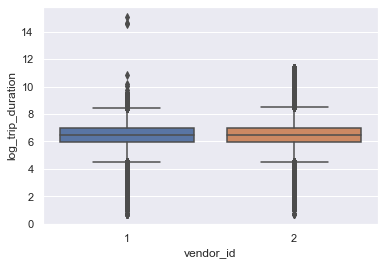

In [120]:
sns.boxplot(x = X_train['vendor_id'], y=y_train)
plt.show()

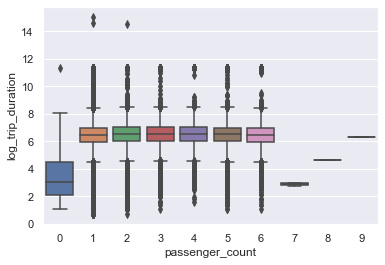

In [121]:
sns.boxplot(x = X_train['passenger_count'], y=y_train)
plt.show()

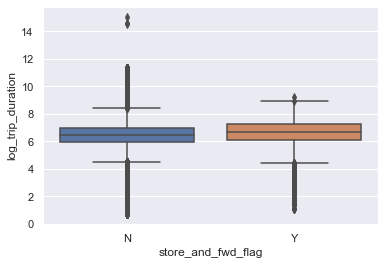

In [122]:
sns.boxplot(x = X_train['store_and_fwd_flag'], y=y_train)
plt.show()

Переведите признаки `vendor_id` и `store_and_fwd_flag` в значения $\{0;1\}$

In [123]:
X_train['vendor_id'] = X_train['vendor_id'].replace({1:0, 2:1})
X_test['vendor_id'] = X_test['vendor_id'].replace({1:0, 2:1})

X_train['store_and_fwd_flag'] = X_train['store_and_fwd_flag'].replace({'N':0, 'Y':1})
X_test['store_and_fwd_flag'] = X_test['store_and_fwd_flag'].replace({'N':0, 'Y':1})

**Вопрос**: Основываясь на графиках выше, как вы думаете, будут ли эти признаки сильными?

Нет, т.к. распределения не сильно отличаются, а вот число пассажирова может сказаться

**Задание 12 (0.25 баллов)**. Проверьте свои предположения, обучив модель в том числе и на этих трех признаках. Обучайте `Ridge`-регрессию со стандартными параметрами. Категориальные признаки закодируйте one-hot-кодированием, а численные отмасштабируйте.

In [124]:
X_train4 = pd.concat([X_train3, X_train[['vendor_id', 'store_and_fwd_flag', 'passenger_count']]], axis=1)
X_test4 = pd.concat([X_test3, X_test[['vendor_id', 'store_and_fwd_flag', 'passenger_count']]], axis=1)

In [125]:
ridge = Ridge()

ridge.fit(X_train4.values, y_train)

Ridge()

In [126]:
prediction4 = ridge.predict(X_test4.values)

In [127]:
mean_squared_log_error(y_test, prediction4)

0.008764582864628412

Если признаки не дали какого-то ощутимого улучшения метрики, их можно выбросить из данных.

## Часть 4. Улучшаем модель (3 балла)

**Задание 13 (1 балл)**. В наших данных есть нетипичные объекты: с аномально маленьким времени поездки, с очень большим пройденным расстоянием или очень большими остатками регрессии. В этом задании предлагается исключить такие объекты из обучающей выборки. Для этого нарисуйте гистограммы распределения упомянутых выше величин, выберите объекты, которые можно назвать выбросами, и очистите обучающую выборку от них.

Отметим, что хотя эти объекты и выглядят как выбросы, в тестовой выборке тоже скорее всего будут объекты с такими же странными значениями целевой переменной и/или признаков. Поэтому, возможно, чистка обучающей выборки приведёт к ухудшению качества на тесте. Тем не менее, всё равно лучше удалять выбросы из обучения, чтобы модель получалась более разумной и интерпретируемой.

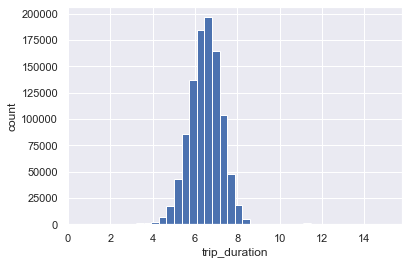

In [128]:
plt.hist(y_train, bins=40)

plt.xlabel('trip_duration')
plt.ylabel('count')
plt.show()

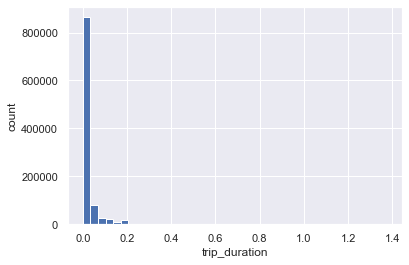

In [129]:
plt.hist(X_train['log_haversine'], bins=40)

plt.xlabel('trip_duration')
plt.ylabel('count')
plt.show()

In [130]:
X_train = X_train[(X_train['log_haversine'] < X_train['log_haversine'].quantile(0.75))]
X_test = X_test[(X_test['log_haversine'] < X_test['log_haversine'].quantile(0.75))]

In [131]:
X_train4 = X_train4.loc[X_train.index]
X_test4 = X_test4.loc[X_test.index]

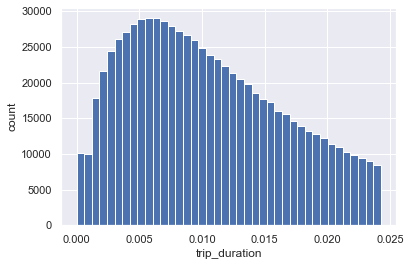

In [132]:
plt.hist(X_train4['log_haversine'], bins=40)

plt.xlabel('trip_duration')
plt.ylabel('count')
plt.show()

In [133]:
ridge = Ridge()

ridge.fit(X_train4.values, y_train.loc[X_train4.index])

Ridge()

In [134]:
prediction4 = ridge.predict(X_test4.values)

In [135]:
mean_squared_log_error(y_test.loc[X_test4.index], prediction4)

0.00908860086569036

Сейчас у нас очень много категориальных признаков. В категориальных признаках могут содержаться редкие категории, обычно это плохо: модель сильно переобучается на таких примерах. Попробуйте объединить редкие категории в одну. Естественно, делать это нужно только для действительно редких категорий.

#### Сейчас для каждого аэропорта отдельно по два признака, однако у них малое количество 1, поэтому объединим их в один признак отвечающий за то, началась ли поездка в аэропорту или закончилась.

In [136]:
X_train['spec_start1'].value_counts()

0    764505
1      1282
Name: spec_start1, dtype: int64

In [137]:
X_train['spec_start2'].value_counts()

0    763943
1      1844
Name: spec_start2, dtype: int64

In [138]:
idx_air_1 = X_train.iloc[np.where(X_train['spec_start1'] == 1)[0]].index
idx_air_2 = X_train.iloc[np.where(X_train['spec_start2'] == 1)[0]].index

In [139]:
X_train['spec_start'] = np.zeros(len(X_train)).astype(int)

In [140]:
X_train.loc[idx_air_1, 'spec_start'] = np.ones(len(idx_air_1)).astype(int)
X_train.loc[idx_air_2, 'spec_start'] = np.ones(len(idx_air_2)).astype(int)

In [141]:
X_train['spec_start'].value_counts()

0    762661
1      3126
Name: spec_start, dtype: int64

In [142]:
idx_air_1 = X_train.iloc[np.where(X_train['spec_end1'] == 1)[0]].index
idx_air_2 = X_train.iloc[np.where(X_train['spec_end2'] == 1)[0]].index

X_train['spec_end'] = np.zeros(len(X_train)).astype(int)

X_train.loc[idx_air_1, 'spec_end'] = np.ones(len(idx_air_1)).astype(int)
X_train.loc[idx_air_2, 'spec_end'] = np.ones(len(idx_air_2)).astype(int)

In [143]:
idx_air_1 = X_test.iloc[np.where(X_test['spec_start1'] == 1)[0]].index
idx_air_2 = X_test.iloc[np.where(X_test['spec_start2'] == 1)[0]].index

X_test['spec_start'] = np.zeros(len(X_test)).astype(int)

X_test.loc[idx_air_1, 'spec_start'] = np.ones(len(idx_air_1)).astype(int)
X_test.loc[idx_air_2, 'spec_start'] = np.ones(len(idx_air_2)).astype(int)

idx_air_1 = X_test.iloc[np.where(X_test['spec_end1'] == 1)[0]].index
idx_air_2 = X_test.iloc[np.where(X_test['spec_end2'] == 1)[0]].index

X_test['spec_end'] = np.zeros(len(X_test)).astype(int)

X_test.loc[idx_air_1, 'spec_end'] = np.ones(len(idx_air_1)).astype(int)
X_test.loc[idx_air_2, 'spec_end'] = np.ones(len(idx_air_2)).astype(int)

Обучите модель на очищенных данных и посчитайте качество на тестовой выборке.

In [144]:
X_train4 = X_train4.drop(['spec_start1', 'spec_start2', 'spec_end1', 'spec_end2'], axis=1)

X_train4['spec_start'] = X_train['spec_start'] 
X_train4['spec_end'] = X_train['spec_end']

X_test4 = X_test4.drop(['spec_start1', 'spec_start2', 'spec_end1', 'spec_end2'], axis=1)

X_test4['spec_start'] = X_test['spec_start'] 
X_test4['spec_end'] = X_test['spec_end']

In [145]:
ridge = Ridge()

ridge.fit(X_train4.values, y_train.loc[X_train4.index])

Ridge()

In [146]:
prediction4 = ridge.predict(X_test4.values)

In [147]:
mean_squared_log_error(y_test.loc[X_test4.index], prediction4)

0.00912953221804212

**Задание 14 (1 балл)**. После OneHot-кодирования количество признаков в нашем датасете сильно возрастает. Посчитайте колиество признаков до и после кодирования категориальных признаков.

In [148]:
len(data_copy.columns)

11

In [149]:
len(X_train4.columns)

206

Попробуйте обучить не `Ridge`-, а `Lasso`-регрессию. Какой метод лучше?

**Ответ**: Лучше Ridge

In [150]:
from sklearn.linear_model import Lasso

In [151]:
lasso = Lasso()

lasso.fit(X_train4.values, y_train.loc[X_train4.index])

Lasso()

In [152]:
prediction_lasso = lasso.predict(X_test4.values)

In [153]:
mean_squared_log_error(y_test.loc[X_test4.index], prediction_lasso)

0.011643929194466161

Разбейте обучающую выборку на обучающую и валидационную в отношении 8:2. По валидационной выборке подберите оптимальные значения параметра регуляризации (по логарифмической сетке) для `Ridge` и `Lasso`, на тестовой выборке измерьте качество лучшей полученной модели.

In [154]:
from sklearn.model_selection import GridSearchCV, train_test_split

In [155]:
X_train5, X_val, y_train5, y_val = train_test_split(X_train4.values, y_train.loc[X_train4.index], test_size=0.2)

parameters = {'alpha': np.logspace(1e-4, 10, 20)}
ridge = Ridge()

cv = GridSearchCV(ridge, parameters, cv=4, scoring="neg_root_mean_squared_error")

cv.fit(X_val, y_val)

cv.best_params_

# ridge_best = cv.best_estimator_

{'alpha': 1.0002302850208247}

In [156]:
# score_array = []
# models = []
# grid = np.linspace(1e-3, 1000, 10)

# for i in grid:
#     ridge = Ridge()
    
#     ridge.fit(X_train5, y_train5)
    
#     pr = ridge.predict(X_val)
    
#     score = mean_squared_log_error(pr, y_val)
    
#     models.append(ridge)
    
#     score_array.append(score)

In [157]:
# scores = sorted(zip(np.arange(len(score_array)), score_array), key=lambda x: x[1])

In [158]:
# ridge_best = models[scores[0][0]]

In [159]:
ridge_best = Ridge(alpha=cv.best_params_['alpha'])

ridge_best.fit(X_train5, y_train5)

Ridge(alpha=1.0002302850208247)

In [160]:
prediction_best_ridge = ridge_best.predict(X_test4.values)

In [161]:
mean_squared_log_error(y_test.loc[X_test4.index], prediction_best_ridge)

0.009132241999845688

In [162]:
parameters = {'alpha': np.logspace(1e-4, 10, 20)}
lasso = Lasso()

cv = GridSearchCV(lasso, parameters, cv=4, scoring="neg_root_mean_squared_error")
cv.fit(X_val, y_val)

GridSearchCV(cv=4, estimator=Lasso(),
             param_grid={'alpha': array([1.00023029e+00, 3.36055128e+00, 1.12907048e+01, 3.79342567e+01,
       1.27450665e+02, 4.28205885e+02, 1.43867653e+03, 4.83363313e+03,
       1.62399322e+04, 5.45625598e+04, 1.83318064e+05, 6.15907921e+05,
       2.06931362e+06, 6.95243348e+06, 2.33586300e+07, 7.84798013e+07,
       2.63674676e+08, 8.85888262e+08, 2.97638751e+09, 1.00000000e+10])},
             scoring='neg_root_mean_squared_error')

In [163]:
# lasso_best = cv.best_estimator_

In [164]:
lasso_best = Lasso(alpha=cv.best_params_['alpha'])

lasso_best.fit(X_train5, y_train5)

Lasso(alpha=1.0002302850208247)

In [165]:
prediction_best_lasso = lasso_best.predict(X_test4.values)

In [166]:
mean_squared_log_error(y_test.loc[X_test4.index], prediction_best_lasso)

0.011643656481594624

Для каждого перебранного `alpha` для Lasso посчитайте количество нулевых весов в модели и нарисуйте график зависимости его от `alpha`. Как сильно придётся потерять в качестве, если мы хотим с помощью Lasso избавиться хотя бы от половины признаков?

In [167]:
grid = np.logspace(-5, 2, 20)
coefs = []

for i in grid:
    lasso = Lasso(alpha = i)
    
    lasso.fit(X_train5, y_train5)
    coefs.append(np.where(lasso.coef_ == 0)[0].shape[0])

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.380e+03, tolerance: 3.202e+01
  model = cd_fast.enet_coordinate_descent(


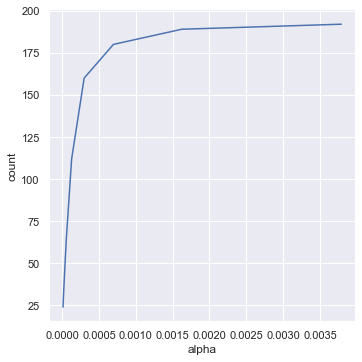

In [168]:
sns.relplot(x = grid[:8], y = coefs[:8], aspect=1, kind='line')

plt.xlabel('alpha')
plt.ylabel('count')

plt.show()

<img src="https://www.dropbox.com/s/wp4jj0599np17lh/map_direction.png?raw=1" width="20%" align="right" style="margin-left: 20px">

**Задание 15 (1 балл)**. Часто бывает полезным использовать взаимодействия признаков (feature interactions), то есть строить новые признаки на основе уже существующих. Выше мы разбили карту Манхэттена на ячейки и придумали признаки "из какой ячейки началась поездка" и "в какой ячейке закончилась поездка".

Давайте попробуем сделать следующее: посчитаем, сколько раз встречается каждая возможная пара этих признаков в нашем датасете и выберем 100 самых частых пар. Закодируем поездки с этими частыми парами как категориальный признак, остальным объектам припишем -1. Получается, что мы закодировали, откуда и куда должно было ехать такси.

Также можете придумать ещё какой-нибудь способ сделать признаки про маршрут. Если эти признаки будут давать хороший прирост в качестве, то за это могут быть даны дополнительные бонусные баллы.

**Вопрос**: Почему такой признак потенциально полезный? Почему линейная модель не может самостоятельно "вытащить" эту информацию, ведь у нее в распоряжении есть признаки "из какой ячейки началась поездка" и "в какой ячейке закончилась поездка"?

**Ответ**: потому что это нелинейный признак, который линейная регрессия не может вытащить, однако он полезен так как определяет конретно откуда началась и где закончилась поездка.

In [251]:
idx_eq = X_train4[X_train4['grid_start'] == X_train4['grid_end']].index
idx_eq_test = X_test4[X_test4['grid_start'] == X_test4['grid_end']].index

In [268]:
X_train4['direction'] = np.array([-1]*len(X_train4))
X_test4['direction'] = np.array([-1]*len(X_test4))

In [267]:
eq_pairs_train = X_train4.loc[idx_eq].groupby(['grid_start', 'grid_end']).count().iloc[:, 0]
eq_pairs_test = X_test4.loc[idx_eq_test].groupby(['grid_start', 'grid_end']).count().iloc[:, 0]

In [270]:
for i in range(len(eq_pairs_train)):
    idx = X_train4.loc[idx_eq][(X_train4.loc[idx_eq]['grid_start'] == eq_pairs_train.index[i][0]) & (X_train4.loc[idx_eq]['grid_end'] == eq_pairs_train.index[i][1])].index
    X_train4.loc[idx, 'direction'] = eq_pairs_train.values[i]
    
for i in range(len(eq_pairs_test)):
    idx = X_test4.loc[idx_eq_test][(X_test4.loc[idx_eq_test]['grid_start'] == eq_pairs_test.index[i][0]) & (X_test4.loc[idx_eq_test]['grid_end'] == eq_pairs_test.index[i][1])].index
    X_test4.loc[idx, 'direction'] = eq_pairs_test.values[i]

In [273]:
X_train4.head()

,dayofweek_0,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6,month_1,month_2,month_3,...,0,log_haversine,grid_start,grid_end,vendor_id,store_and_fwd_flag,passenger_count,spec_start,spec_end,direction
92034,0,0,0,0,1,0,0,0,1,0,...,0.999087,0.009000,7,7,1,0,1,0,0,78533
1217977,0,0,0,0,0,0,1,0,0,0,...,-1.501438,0.010958,10,9,0,0,1,0,0,-1
599787,0,0,0,1,0,0,0,0,0,0,...,-0.563741,0.003215,1,4,0,0,1,0,0,-1
576077,1,0,0,0,0,0,0,0,0,1,...,-0.094893,0.016675,7,6,0,0,1,0,0,-1
488004,1,0,0,0,0,0,0,0,0,0,...,-0.094893,0.004396,6,10,1,0,2,0,0,-1


Заново обучите модель (`Ridge`, если она дала более высокое качество в предыдущих экспериментах, и `Lasso` иначе) на новых даннных и посчитайте качество на тестовой выборке

In [283]:
ridge_best = Ridge(alpha=cv.best_params_['alpha'])

ridge_best.fit(X_train4.values, y_train[X_train4.index])

Ridge(alpha=1.0002302850208247)

In [284]:
prediction_best_ridge = ridge_best.predict(X_test4.values)

In [285]:
mean_squared_log_error(y_test.loc[X_test4.index], prediction_best_ridge)

0.009097684043477149